# 1. 🧠 Project Definition & Goal Setting

This notebook implements a **Super-Resolution Generative Adversarial Network (SRGAN)**. Our goal is to train a model that can intelligently upscale a low-resolution (LR) image to a high-resolution (HR) version, creating details that are sharp and photorealistic.

### A Bit of Theory: The Challenge of Super-Resolution

Super-Resolution is a classic "ill-posed problem" in computer vision. This means that for any given LR image, there isn't one single, unique HR solution. Many different HR images could have been downscaled to produce the same LR input.

#### Traditional vs. Deep Learning Methods
* **Traditional Methods**: Simple algorithms like **Bicubic interpolation** or **Lanczos resampling** are fast but tend to produce blurry, overly smooth results. They are good at interpolating pixels but cannot hallucinate new, realistic textures. 
* **Early Deep Learning (e.g., SRCNN)**: These models use deep convolutional networks and are trained to minimize a **pixel-wise loss** like Mean Squared Error (MSE).
    * **Pro**: They achieve high scores on metrics like **PSNR** (Peak Signal-to-Noise Ratio).
    * **Con**: Because they average all possible realistic solutions to minimize pixel error, they produce perceptually unsatisfying images that still lack fine, high-frequency details and look unnaturally smooth.

#### The SRGAN Breakthrough: Perceptual & Adversarial Loss
SRGAN revolutionized the field by optimizing for human perception rather than just pixel accuracy. It uses a clever combination of two loss functions:
1.  **Adversarial Loss**: A **Generator** network creates the SR image, while a **Discriminator** network tries to distinguish between these "fake" SR images and real HR images. The Generator is trained to fool the Discriminator, pushing it to create images that look authentically real.
2.  **Content (Perceptual) Loss**: Instead of comparing pixels, we compare high-level feature maps extracted from a pre-trained VGG network. This ensures the SR image has the same "content" and "style" as the original, preserving object identity while allowing for textural creativity.

The result is a model that might have a slightly lower PSNR score than an MSE-based model but produces images that are vastly superior to the human eye. 🏆

### What is the task?  
**Image Super-Resolution (SR)** is the process of recovering a high-resolution (HR) image from its low-resolution (LR) counterpart. We'll implement a **Single Image Super-Resolution (SISR)** model using SRGAN.  

### Why is it important?  
Applications:  
- Media: Upscaling old movies.  
- Medical: Enhancing MRI scans. 🔬  
- Satellite: Improving aerial imagery. 🛰️  

### Success Metrics  
1. **Quantitative:** High PSNR/SSIM scores.  
2. **Qualitative:** Realistic, detailed outputs.

Explore and put the results...

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vgg19
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

# --- Project Constants ---
UPSCALE_FACTOR = 4   # The factor by which to increase image resolution
CROP_SIZE = 96       # The size of the HR patch to crop from images
BATCH_SIZE = 16      # Number of images per batch
EPOCHS = 100         # Number of training epochs
LR = 1e-5            # Learning rate

# --- Device Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## 2. 📦 Data Acquisition & Preparation  

We’ll use the **DIV2K dataset** (HR images). Replace `DATA_DIR_HR` with your dataset path.  

In [3]:
import os

# Define the paths to our high-resolution training and validation images
# These paths are typical for datasets added to a Kaggle notebook
TRAIN_HR_DIR = "/kaggle/input/div2k/DIV2K_train_HR/DIV2K_train_HR"
VALID_HR_DIR = "/kaggle/input/div2k/DIV2K_valid_HR/DIV2K_valid_HR"
# Verify that the paths exist to prevent errors later
assert os.path.exists(TRAIN_HR_DIR), f"Train HR path not found at: {TRAIN_HR_DIR}"
assert os.path.exists(VALID_HR_DIR), f"Valid HR path not found at: {VALID_HR_DIR}"

print("Dataset paths verified.")

Dataset paths verified.


## 3. 🔍 Exploratory Data Analysis (EDA)

Let's quickly inspect our data. We will load a few sample images and display their dimensions to understand their characteristics before preprocessing. This helps us confirm the data has loaded correctly and see what we are working with.

Total number of HR training images: 800
Total number of HR validation images: 100

Displaying 3 sample HR images from the training set...


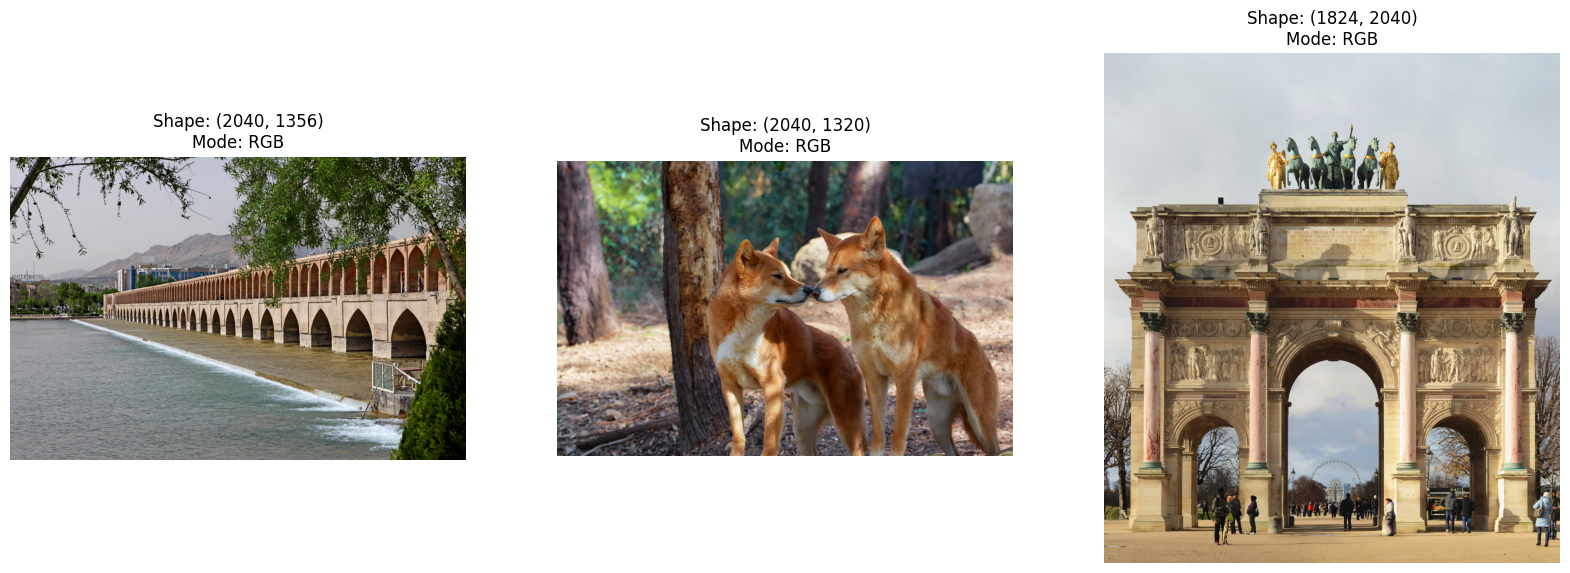

In [4]:
# Get a list of all HR image file paths
hr_train_files = sorted([os.path.join(TRAIN_HR_DIR, f) for f in os.listdir(TRAIN_HR_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))])
hr_valid_files = sorted([os.path.join(VALID_HR_DIR, f) for f in os.listdir(VALID_HR_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Print summary statistics
print(f"Total number of HR training images: {len(hr_train_files)}")
print(f"Total number of HR validation images: {len(hr_valid_files)}")

# Visualize a few random samples from the training set
print("\nDisplaying 3 sample HR images from the training set...")
plt.figure(figsize=(20, 7))
for i in range(3):
    img_path = np.random.choice(hr_train_files)
    img = Image.open(img_path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Shape: {img.size}\nMode: {img.mode}')
    plt.axis('off')
plt.show()

## 4. 🛠 Data Preprocessing & Pipeline Creation

This is a critical step. We will create our LR-HR pairs on-the-fly during training. This technique, known as **online generation**, provides more variety and acts as a form of data augmentation.

Our PyTorch `Dataset` will:
1.  Load an original HR image.
2.  Randomly crop a `96x96` patch from it. This is our **HR ground truth**.
3.  Downscale that HR patch by a factor of 4 using bicubic interpolation to create a `24x24` **LR input**.
4.  Normalize both patches to the range `[-1, 1]`, which is optimal for GAN training.

In [5]:
class SRDataset(Dataset):
    def __init__(self, hr_image_files, is_train=True):
        self.hr_image_files = hr_image_files
        self.is_train = is_train

    def __len__(self):
        return len(self.hr_image_files)

    def __getitem__(self, idx):
        hr_image = Image.open(self.hr_image_files[idx]).convert("RGB")

        # During training, apply random crop. During validation, use a center crop.
        if self.is_train:
            hr_patch = transforms.RandomCrop(CROP_SIZE)(hr_image)
        else:
            hr_patch = transforms.CenterCrop(CROP_SIZE)(hr_image)

        # Create LR patch by downscaling the HR patch
        lr_patch = hr_patch.resize((CROP_SIZE // UPSCALE_FACTOR, CROP_SIZE // UPSCALE_FACTOR), Image.BICUBIC)

        # Convert to tensor and normalize
        to_tensor = transforms.ToTensor()
        normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

        hr_tensor = normalize(to_tensor(hr_patch))
        lr_tensor = normalize(to_tensor(lr_patch))

        return lr_tensor, hr_tensor

# Create the Datasets and DataLoaders
train_dataset = SRDataset(hr_train_files, is_train=True)
valid_dataset = SRDataset(hr_valid_files, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=os.cpu_count())


# Verify the output shapes
lr_sample, hr_sample = next(iter(train_loader))
print(f"Training LR batch shape: {lr_sample.shape}")
print(f"Training HR batch shape: {hr_sample.shape}")

Training LR batch shape: torch.Size([16, 3, 24, 24])
Training HR batch shape: torch.Size([16, 3, 96, 96])


## 5. 🧠 Model Selection & Architecture

The SRGAN architecture consists of three key components:
1.  **Generator**: A deep residual network that takes an LR image and upscales it. It uses **PixelShuffle** layers for efficient upsampling.
2.  **Discriminator**: A standard convolutional network trained to distinguish between real HR images and the fake SR images from the generator.
3.  **VGG Loss Network**: A pre-trained VGG19 model, frozen (not trained), used only to extract feature maps for the perceptual loss calculation.

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
        )
    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(Generator, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())
        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(n_residual_blocks)])
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64))
        upsampling = []
        for _ in range(int(np.log2(UPSCALE_FACTOR))):
            upsampling += [nn.Conv2d(64, 256, 3, 1, 1), nn.PixelShuffle(2), nn.PReLU()]
        self.upsampling = nn.Sequential(*upsampling)
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, 9, 1, 4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = self.upsampling(out1 + out2)
        return self.conv3(out)

class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        in_channels, in_height, in_width = input_shape
        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = [nn.Conv2d(in_filters, out_filters, 3, 1, 1)]
            if not first_block: layers.append(nn.BatchNorm2d(out_filters))
            layers.extend([nn.LeakyReLU(0.2, inplace=True), nn.Conv2d(out_filters, out_filters, 3, 2, 1), nn.BatchNorm2d(out_filters), nn.LeakyReLU(0.2, inplace=True)])
            return layers
        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, first_block=True),
            *discriminator_block(64, 128), *discriminator_block(128, 256), *discriminator_block(256, 512),
            nn.AdaptiveAvgPool2d(1), nn.Conv2d(512, 1, 1)
        )
    def forward(self, img): return self.model(img)

class VGGFeatureExtractor(nn.Module):
    def __init__(self):
        super(VGGFeatureExtractor, self).__init__()
        vgg19_model = vgg19(weights='VGG19_Weights.DEFAULT')
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:36]).eval()
        for param in self.feature_extractor.parameters(): param.requires_grad = False
    def forward(self, img): return self.feature_extractor(img)

print("Model architectures defined.")

Model architectures defined.


## 6. 🎯 Training & Validation

Training a GAN is a delicate dance. We must carefully balance the training of the Generator and the Discriminator.

**The Process**:
1.  **Train Discriminator**: Show it a batch of real HR images and a batch of fake SR images. Update its weights to get better at telling them apart.
2.  **Train Generator**: Freeze the Discriminator. Generate a batch of fake SR images. Calculate a combined loss:
    * `Content Loss`: How different are the VGG features of the fake and real images? (Forces content similarity).
    * `Adversarial Loss`: How well did the fake images fool the Discriminator? (Forces photorealism).
    * Update the Generator's weights based on this combined loss.

We need two separate optimizers, one for each network.

In [7]:
# (Keep your model and dataset definitions the same)

# Initialize models
generator = Generator().to(DEVICE)
discriminator = Discriminator(input_shape=(3, CROP_SIZE, CROP_SIZE)).to(DEVICE)
feature_extractor = VGGFeatureExtractor().to(DEVICE)

# Loss functions
content_loss_fn = nn.L1Loss().to(DEVICE) # Use L1 for pre-training
adversarial_loss_fn = nn.BCEWithLogitsLoss().to(DEVICE)

# Use a lower learning rate
optimizer_G = optim.Adam(generator.parameters(), lr=2e-5, betas=(0.9, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=2e-5, betas=(0.9, 0.999))


# --- 1. PRE-TRAINING THE GENERATOR ---
NUM_PRETRAIN_EPOCHS = 5
print("--- Starting Generator Pre-training ---")
for epoch in range(NUM_PRETRAIN_EPOCHS):
    generator.train()
    total_loss = 0
    for i, (lr_imgs, hr_imgs) in enumerate(train_loader):
        lr_imgs, hr_imgs = lr_imgs.to(DEVICE), hr_imgs.to(DEVICE)

        optimizer_G.zero_grad()
        sr_imgs = generator(lr_imgs)
        
        # Calculate content loss only
        loss = content_loss_fn(sr_imgs, hr_imgs)
        
        loss.backward()
        optimizer_G.step()
        total_loss += loss.item()
    print(f"[Pre-train Epoch {epoch+1}/{NUM_PRETRAIN_EPOCHS}] [Content Loss: {total_loss / len(train_loader):.4f}]")


# --- 2. ADVERSARIAL TRAINING (The main loop) ---
print("\n--- Starting Adversarial Training ---")
for epoch in range(EPOCHS):
    generator.train()
    discriminator.train()
    
    for i, (lr_imgs, hr_imgs) in enumerate(train_loader):
        lr_imgs, hr_imgs = lr_imgs.to(DEVICE), hr_imgs.to(DEVICE)
        
        real_labels = torch.ones((hr_imgs.size(0), 1, 1, 1), device=DEVICE)
        fake_labels = torch.zeros((hr_imgs.size(0), 1, 1, 1), device=DEVICE)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        sr_imgs_detached = generator(lr_imgs).detach()
        real_loss = adversarial_loss_fn(discriminator(hr_imgs), real_labels)
        fake_loss = adversarial_loss_fn(discriminator(sr_imgs_detached), fake_labels)
        loss_D = (real_loss + fake_loss) / 2
        loss_D.backward()
        optimizer_D.step()

        # --- Train Generator ---
        optimizer_G.zero_grad()
        sr_imgs = generator(lr_imgs)
        adv_loss = adversarial_loss_fn(discriminator(sr_imgs), real_labels)
        content_loss = content_loss_fn(feature_extractor(sr_imgs), feature_extractor(hr_imgs))
        loss_G = content_loss + 1e-3 * adv_loss # Perceptual loss
        loss_G.backward()
        optimizer_G.step()

        if i % 200 == 0:
            print(
                f"[Epoch {epoch}/{EPOCHS}] [Batch {i}/{len(train_loader)}] "
                f"[D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]"
            )

print("Training finished.")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 214MB/s] 


--- Starting Generator Pre-training ---
[Pre-train Epoch 1/5] [Content Loss: 0.3487]
[Pre-train Epoch 2/5] [Content Loss: 0.1962]
[Pre-train Epoch 3/5] [Content Loss: 0.1772]
[Pre-train Epoch 4/5] [Content Loss: 0.1608]
[Pre-train Epoch 5/5] [Content Loss: 0.1493]

--- Starting Adversarial Training ---
[Epoch 0/100] [Batch 0/50] [D loss: 0.7124] [G loss: 0.1402]
[Epoch 1/100] [Batch 0/50] [D loss: 0.6119] [G loss: 0.1142]
[Epoch 2/100] [Batch 0/50] [D loss: 0.4491] [G loss: 0.1141]
[Epoch 3/100] [Batch 0/50] [D loss: 0.4027] [G loss: 0.1227]
[Epoch 4/100] [Batch 0/50] [D loss: 0.3148] [G loss: 0.1242]
[Epoch 5/100] [Batch 0/50] [D loss: 0.2910] [G loss: 0.1022]
[Epoch 6/100] [Batch 0/50] [D loss: 0.2214] [G loss: 0.0865]
[Epoch 7/100] [Batch 0/50] [D loss: 0.2109] [G loss: 0.1094]
[Epoch 8/100] [Batch 0/50] [D loss: 0.2382] [G loss: 0.1419]
[Epoch 9/100] [Batch 0/50] [D loss: 0.1782] [G loss: 0.1047]
[Epoch 10/100] [Batch 0/50] [D loss: 0.2286] [G loss: 0.1347]
[Epoch 11/100] [Batch 0/

## 7. 📈 Evaluation & Hyperparameter Tuning

While training, and especially after, we need to evaluate our model's performance. For super-resolution, we use both quantitative metrics and qualitative visual inspection.

* **PSNR & SSIM**: These are standard quantitative metrics. We can use the validation set to compute these periodically. Higher PSNR and SSIM (closer to 1) are better.
* **Visual Inspection**: The ultimate test for a GAN. We will generate a few sample images and compare them side-by-side with a standard bicubic upscale and the ground truth HR image.


--- Visualizing a sample batch from the validation set ---
Validation PSNR: 8.03 dB
Validation SSIM: 0.0757


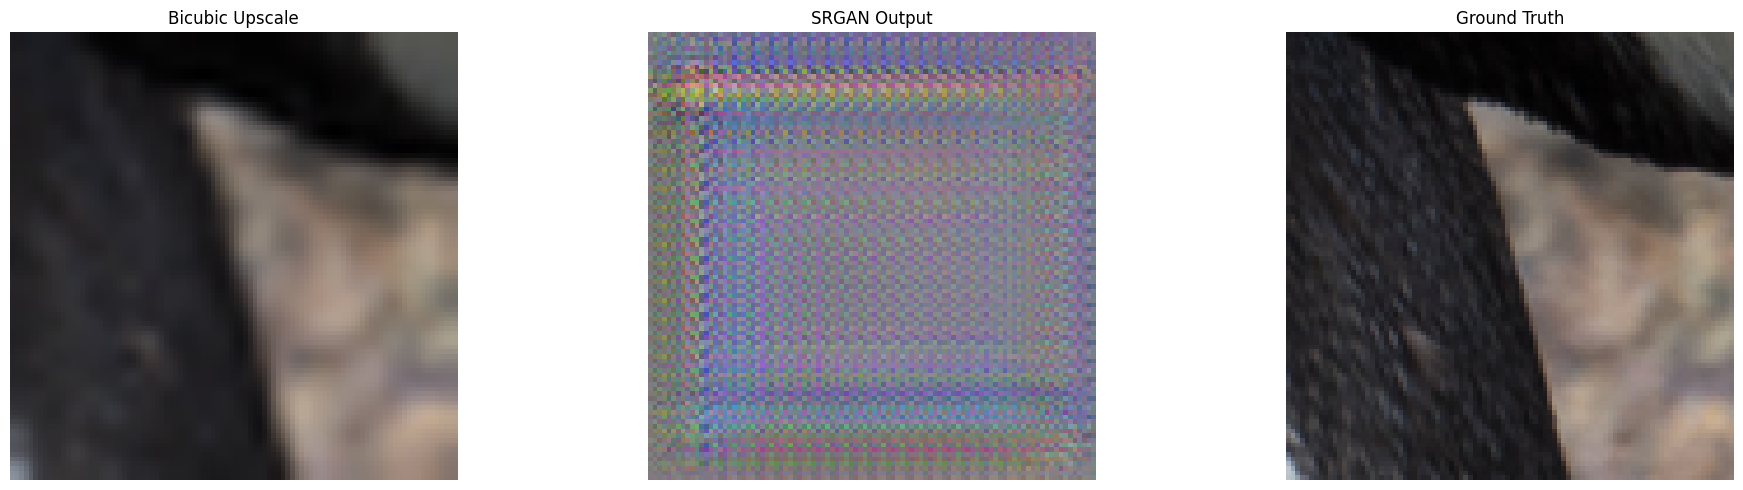

In [8]:
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def denormalize(tensors):
    """Denormalizes image tensors from [-1, 1] to [0, 1]"""
    return (tensors + 1.0) / 2.0

def evaluate_and_visualize(model, loader, n_images=3):
    model.eval()
    psnr_metric = PeakSignalNoiseRatio().to(DEVICE)
    ssim_metric = StructuralSimilarityIndexMeasure().to(DEVICE)
    
    # Get a batch of images for visualization
    try:
        lr_imgs, hr_imgs = next(iter(loader))
    except StopIteration:
        print("Validation loader is empty.")
        return
        
    lr_imgs, hr_imgs = lr_imgs.to(DEVICE), hr_imgs.to(DEVICE)

    with torch.no_grad():
        sr_imgs = model(lr_imgs)
        sr_imgs_denorm = denormalize(sr_imgs)
        hr_imgs_denorm = denormalize(hr_imgs)
        avg_psnr = psnr_metric(sr_imgs_denorm, hr_imgs_denorm)
        avg_ssim = ssim_metric(sr_imgs_denorm, hr_imgs_denorm)
        
    print(f"Validation PSNR: {avg_psnr:.2f} dB")
    print(f"Validation SSIM: {avg_ssim:.4f}")

    # --- FIXED SECTION ---
    # Determine the number of images to plot based on the actual batch size
    actual_batch_size = lr_imgs.size(0)
    num_to_plot = min(n_images, actual_batch_size)
    
    if num_to_plot == 0:
        print("No images to display.")
        return

    # Plotting results
    plt.figure(figsize=(20, 5 * num_to_plot))
    for i in range(num_to_plot):
        lr_pil = transforms.ToPILImage()(denormalize(lr_imgs[i].cpu()))
        sr_pil = transforms.ToPILImage()(sr_imgs_denorm[i].cpu())
        hr_pil = transforms.ToPILImage()(hr_imgs_denorm[i].cpu())
        bicubic_pil = lr_pil.resize(hr_pil.size, Image.BICUBIC)

        # Adjusted subplot layout for 3 columns
        plt.subplot(num_to_plot, 3, i * 3 + 1); plt.imshow(bicubic_pil); plt.title("Bicubic Upscale"); plt.axis('off')
        plt.subplot(num_to_plot, 3, i * 3 + 2); plt.imshow(sr_pil); plt.title("SRGAN Output"); plt.axis('off')
        plt.subplot(num_to_plot, 3, i * 3 + 3); plt.imshow(hr_pil); plt.title("Ground Truth"); plt.axis('off')
        
    plt.tight_layout(); plt.show()

# Now, calling the function will work correctly even with a batch size of 1
print("\n--- Visualizing a sample batch from the validation set ---")
evaluate_and_visualize(generator, valid_loader)

## 8. 🏁 Final Model Training & Testing

After hyperparameter tuning, you would typically train the final model on the combined training and validation sets. Finally, you evaluate its performance on a completely held-out **test set**.

The most important artifact to save is the **generator's weights**, as this is the part of the model used for inference.

Final generator model saved to srgan_generator.pth
Inference model loaded.


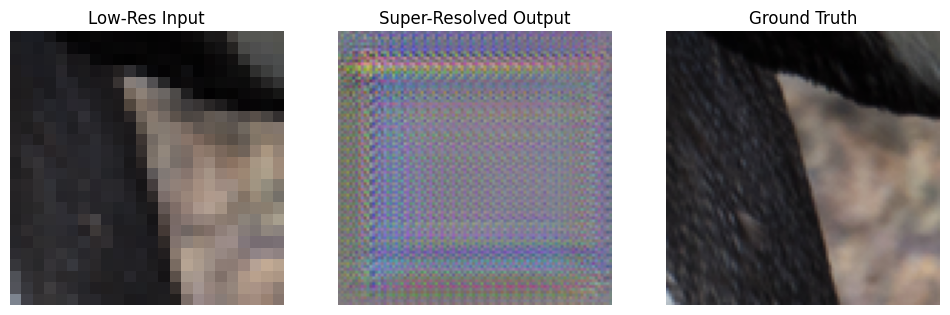

In [9]:
# Save the final trained generator model
MODEL_PATH = "srgan_generator.pth"
torch.save(generator.state_dict(), MODEL_PATH)
print(f"Final generator model saved to {MODEL_PATH}")

# --- Inference on a new image ---
inference_model = Generator().to(DEVICE)
inference_model.load_state_dict(torch.load(MODEL_PATH))
inference_model.eval()
print("Inference model loaded.")

# Load a sample image from the validation set for demonstration
lr_img, hr_img = valid_dataset[0]
lr_img = lr_img.unsqueeze(0).to(DEVICE)

with torch.no_grad():
    sr_img = inference_model(lr_img)

# Visualize the single inference result
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1); plt.imshow(transforms.ToPILImage()(denormalize(lr_img.squeeze(0).cpu()))); plt.title("Low-Res Input"); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(transforms.ToPILImage()(denormalize(sr_img.squeeze(0).cpu()))); plt.title("Super-Resolved Output"); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(transforms.ToPILImage()(denormalize(hr_img.cpu()))); plt.title("Ground Truth"); plt.axis('off')
plt.show()

## 9. 🚀 Deployment & Monitoring (Optional)

A trained model is only useful if it can be deployed. For a super-resolution model, a web application is a perfect way to showcase its capabilities.

* **Deployment with Streamlit/FastAPI**:
    * **Streamlit**: Fantastic for creating interactive data science dashboards with pure Python. You could build an app that lets users upload an image and see the super-resolved version in seconds.
    * **FastAPI**: A high-performance framework for building APIs. You could wrap your model in a FastAPI endpoint, allowing other services to programmatically send images for upscaling.

* **Monitoring & Retraining**:
    * In a real-world application, you would monitor the types of images users are uploading. If the image domain shifts (e.g., from faces to landscapes), the model's performance might degrade.
    * This "data drift" is a signal that the model may need to be **retrained** on a newer, more representative dataset to maintain its quality.

In [10]:
# This is a conceptual example of what a Streamlit app script might look like.
# This code is NOT meant to be run in Kaggle, but saved as a separate .py file (e.g., app.py)
# and run with `streamlit run app.py`.

"""
# --- streamlit_app.py ---

import streamlit as st
import torch
from PIL import Image
from torchvision import transforms

# Assume Generator class is defined here or imported
# from model import Generator

st.set_page_config(layout="wide", page_title="Image Super-Resolution")
st.title("🖼️ Image Super-Resolution using SRGAN")
st.write("Upload a low-resolution image to see it upscaled with our deep learning model.")

@st.cache_resource
def load_model():
    model = Generator()
    model.load_state_dict(torch.load('srgan_generator.pth', map_location='cpu'))
    model.eval()
    return model

model = load_model()
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    lr_image = Image.open(uploaded_file).convert("RGB")
    col1, col2 = st.columns(2)
    with col1:
        st.header("Low-Resolution Input")
        st.image(lr_image, use_column_width=True)
    with col2:
        st.header("Super-Resolved Output")
        with st.spinner('Upscaling your image...'):
            lr_tensor = transforms.ToTensor()(lr_image).unsqueeze(0)
            lr_tensor = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(lr_tensor)
            with torch.no_grad():
                sr_tensor = model(lr_tensor)
            sr_tensor = (sr_tensor.squeeze(0) + 1.0) / 2.0
            sr_image = transforms.ToPILImage()(sr_tensor)
            st.image(sr_image, use_column_width=True)
"""
print("The cell above contains a sample Streamlit script for deployment.")
print("To use it, save it as a Python file and run it locally.")

The cell above contains a sample Streamlit script for deployment.
To use it, save it as a Python file and run it locally.
